In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import precision_recall_curve, roc_curve, auc
import matplotlib.pyplot as plt

In [87]:
final_train_cols

['ordered_before',
 'abandoned_before',
 'avg_days_to_buy_variant_id',
 'global_popularity',
 'normalised_price']

In [84]:
# Cargamos los datos del modelo
DATA_PATH = 'files/feature_frame.csv'
ORDERS_PATH = 'files/orders.parquet'
df_base = pd.read_csv(DATA_PATH)

### Información básica

In [3]:
df_base.head(3)

,variant_id,product_type,order_id,user_id,created_at,order_date,user_order_seq,outcome,ordered_before,abandoned_before,...,count_children,count_babies,count_pets,people_ex_baby,days_since_purchase_variant_id,avg_days_to_buy_variant_id,std_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,std_days_to_buy_product_type
0,33826472919172,ricepastapulses,2807985930372,3482464092292,2020-10-05 16:46:19,2020-10-05 00:00:00,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
1,33826472919172,ricepastapulses,2808027644036,3466586718340,2020-10-05 17:59:51,2020-10-05 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
2,33826472919172,ricepastapulses,2808099078276,3481384026244,2020-10-05 20:08:53,2020-10-05 00:00:00,4,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618


In [4]:
df_base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2880549 entries, 0 to 2880548
Data columns (total 27 columns):
 #   Column                            Dtype  
---  ------                            -----  
 0   variant_id                        int64  
 1   product_type                      object 
 2   order_id                          int64  
 3   user_id                           int64  
 4   created_at                        object 
 5   order_date                        object 
 6   user_order_seq                    int64  
 7   outcome                           float64
 8   ordered_before                    float64
 9   abandoned_before                  float64
 10  active_snoozed                    float64
 11  set_as_regular                    float64
 12  normalised_price                  float64
 13  discount_pct                      float64
 14  vendor                            object 
 15  global_popularity                 float64
 16  count_adults                      fl

### Dividimos las columnas como hicimos en el EDA

In [5]:
target  = 'outcome'
info_cols = ['variant_id', 'order_id', 'user_id', 'created_at', 'order_date']
feature_cols = [_ for _ in df_base.columns if _ not in [target] + info_cols]
binary_cols = ['ordered_before', 'abandoned_before', 'active_snoozed', 'set_as_regular'] 
categ_cols = ['product_type', 'vendor']
numeric_cols = [col for col in feature_cols if col not in binary_cols + categ_cols]
train_cols = numeric_cols + binary_cols

### Definición perímetro

In [6]:
def perim_modelo(df: pd.DataFrame, min_items: int = 5) -> pd.DataFrame:
    """
    Given a df that has columns id | order_id it generates a new dataframe which
    contains the orders that have more items than the argument min_items
    """
    assert {'variant_id', 'order_id'}.issubset(set(df.columns))
    order_counts = df.groupby('order_id').size().reset_index(name='item_count')
    order_counts_filtered = order_counts[order_counts['item_count'] >= min_items]
    df = df.merge(order_counts_filtered, on='order_id', how='inner')
    return df

def col_to_datetime(df: pd.DataFrame, col_name: str) -> pd.DataFrame:
    assert col_name in df.columns
    try:
        df[col_name] = pd.to_datetime(df[col_name])
    except:
        print(f"Could not change types at {df.head()}, with column {col_name}")
    return df


In [7]:

df_base = (
    df_base
        .pipe(perim_modelo, 5)
        .pipe(col_to_datetime, 'order_date')
        .pipe(col_to_datetime, 'created_at')
)



In [8]:
df_base.dtypes

variant_id                                   int64
product_type                                object
order_id                                     int64
user_id                                      int64
created_at                          datetime64[ns]
order_date                          datetime64[ns]
user_order_seq                               int64
outcome                                    float64
ordered_before                             float64
abandoned_before                           float64
active_snoozed                             float64
set_as_regular                             float64
normalised_price                           float64
discount_pct                               float64
vendor                                      object
global_popularity                          float64
count_adults                               float64
count_children                             float64
count_babies                               float64
count_pets                     

### Split temporal
Se opta por uno basado en el tiempo, por la condición de serie temporal del _dataset_.
_Split_ 70, 20, 10.

In [9]:
# Necesitamos la fecha de corte
ORDER_DATE = 'order_date'
df_base.sort_values(by=ORDER_DATE, inplace=True)
quantiles = df_base[ORDER_DATE].quantile([0.7, 0.9, 1.0])

# Extract the values for each quantile
quantile_0 = df_base[ORDER_DATE].min()
quantile_70 = quantiles.iloc[0]
quantile_90 = quantiles.iloc[1]
quantile_100 = quantiles.iloc[2]

print(f"Start: {quantile_0}\n q_70: {quantile_70}\n q_90: {quantile_90}\n End: {quantile_100}")

# Creamos divisiones en base al dato
df_train = df_base[df_base['order_date'] <= quantile_70]
df_val = df_base[(df_base['order_date'] > quantile_70) & (df_base['order_date'] <= quantile_90)]
df_test = df_base[df_base['order_date'] > quantile_90]

# Los datos quedan cortos, pero cubre al menos una semana, aunque no termina de ver un ciclo completo de dias de pago.

Start: 2020-10-05 00:00:00
 q_70: 2021-02-10 00:00:00
 q_90: 2021-02-25 00:00:00
 End: 2021-03-03 00:00:00


In [10]:
# generamos los splits
X_train = df_train.drop('outcome', axis=1)
y_train = df_train['outcome']

X_val = df_val.drop('outcome', axis=1)
y_val = df_val['outcome']

X_test = df_test.drop('outcome', axis=1)
y_test = df_test['outcome']


### Modelo base para poder comparar.

La popularidad, ya nos da un score, y un score razonable para decidir hacer un _baseline_. Un producto es popular porque se compra mucho, es razonable entonces construir un modelo sencillo basado en esto.

In [11]:
df_base[['global_popularity']]

,global_popularity
0,0.000000
1981740,0.000000
68955,0.000000
68956,0.000000
68957,0.000000
...,...
2385182,0.000714
2385183,0.000714
2385184,0.000714
2385186,0.000714


In [12]:
y_val

1225266    0.0
1225267    0.0
1039297    0.0
2132012    0.0
1039298    0.0
          ... 
119326     0.0
1060552    0.0
119325     0.0
119324     0.0
1060551    0.0
Name: outcome, Length: 593990, dtype: float64

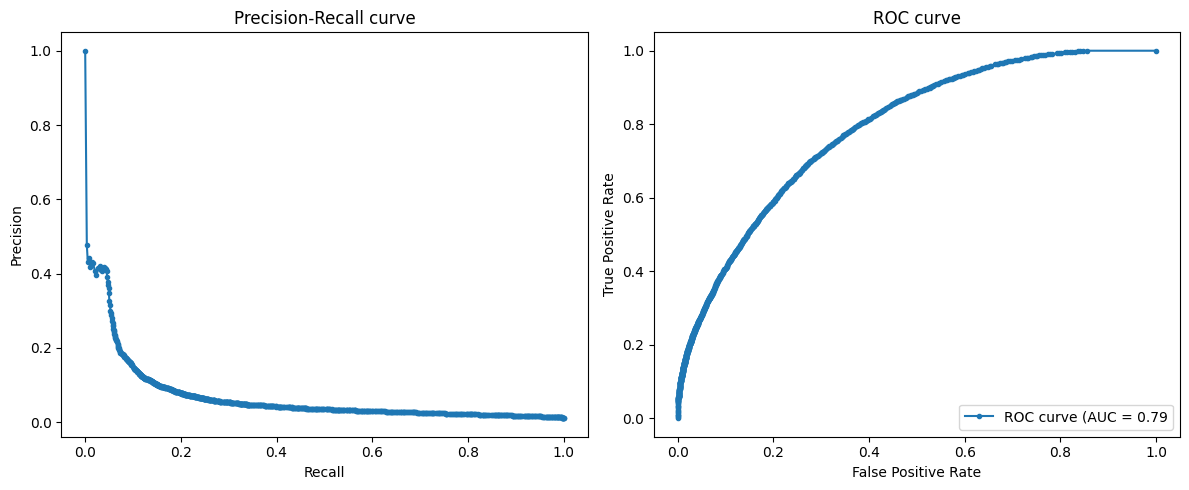

In [13]:
# plots
y_val_base = X_val['global_popularity']



precision, recall, _ = precision_recall_curve(y_val, y_val_base)
fpr, tpr, _ = roc_curve(y_val, y_val_base)

roc_auc = auc(fpr, tpr)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(recall, precision, marker='.')
plt.title('Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')

plt.subplot(1, 2, 2)
plt.plot(fpr, tpr, marker='.', label=f'ROC curve (AUC = {roc_auc:.2f}')  # Add AUC to label
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')  # Add legend

plt.tight_layout()
plt.show()


Es un modelo bastante razonable, para entender como de "fácil" es el problema. Probemos ahora con modelos lineales.

### Sin regularizar

In [14]:
def generate_metrics(ax1, ax2, y_pred_prob: np.ndarray, y_test: np.ndarray, label: str) -> None:
    precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    # PR-curve
    ax1.plot(recall, precision, marker='.', label=f'{label}')
    ax1.set_title('Precision-Recall curve')
    ax1.set_xlabel('Recall')
    ax1.set_ylabel('Precision')
    ax1.legend(loc='best')

    # Roc-curve
    ax2.plot(fpr, tpr, marker='.', label=f'{label} (AUC = {roc_auc:.2f})')
    ax2.set_title('ROC curve')
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.legend(loc='best')


In [15]:
# Modelo
pipeline = Pipeline([
    ('scaler', StandardScaler()),    
    ('log_reg', LogisticRegression())
])

pipeline.fit(X_train[train_cols], y_train)

y_pred = pipeline.predict_proba(X_test[train_cols])[:, 1]

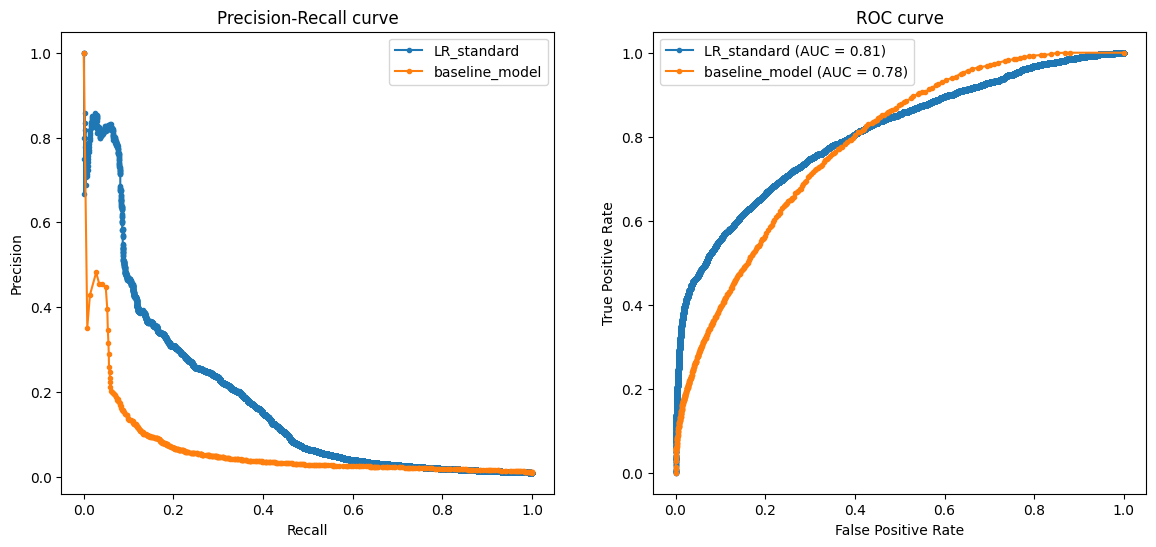

In [16]:
# Comparacion de metricas
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))


generate_metrics(ax1, ax2, y_pred, y_test, label='LR_standard')
generate_metrics(ax1, ax2, X_test['global_popularity'], y_test, label='baseline_model')

El AUC es bastante similar en ambos casos, pero el modelo que utiliza la regresión logística nos permite quedarnos con en un ratio mucho más bajo de FPR con mayores ratios de TPR, que es lo que nos interesa para este tipo de problemas.


### Lasso

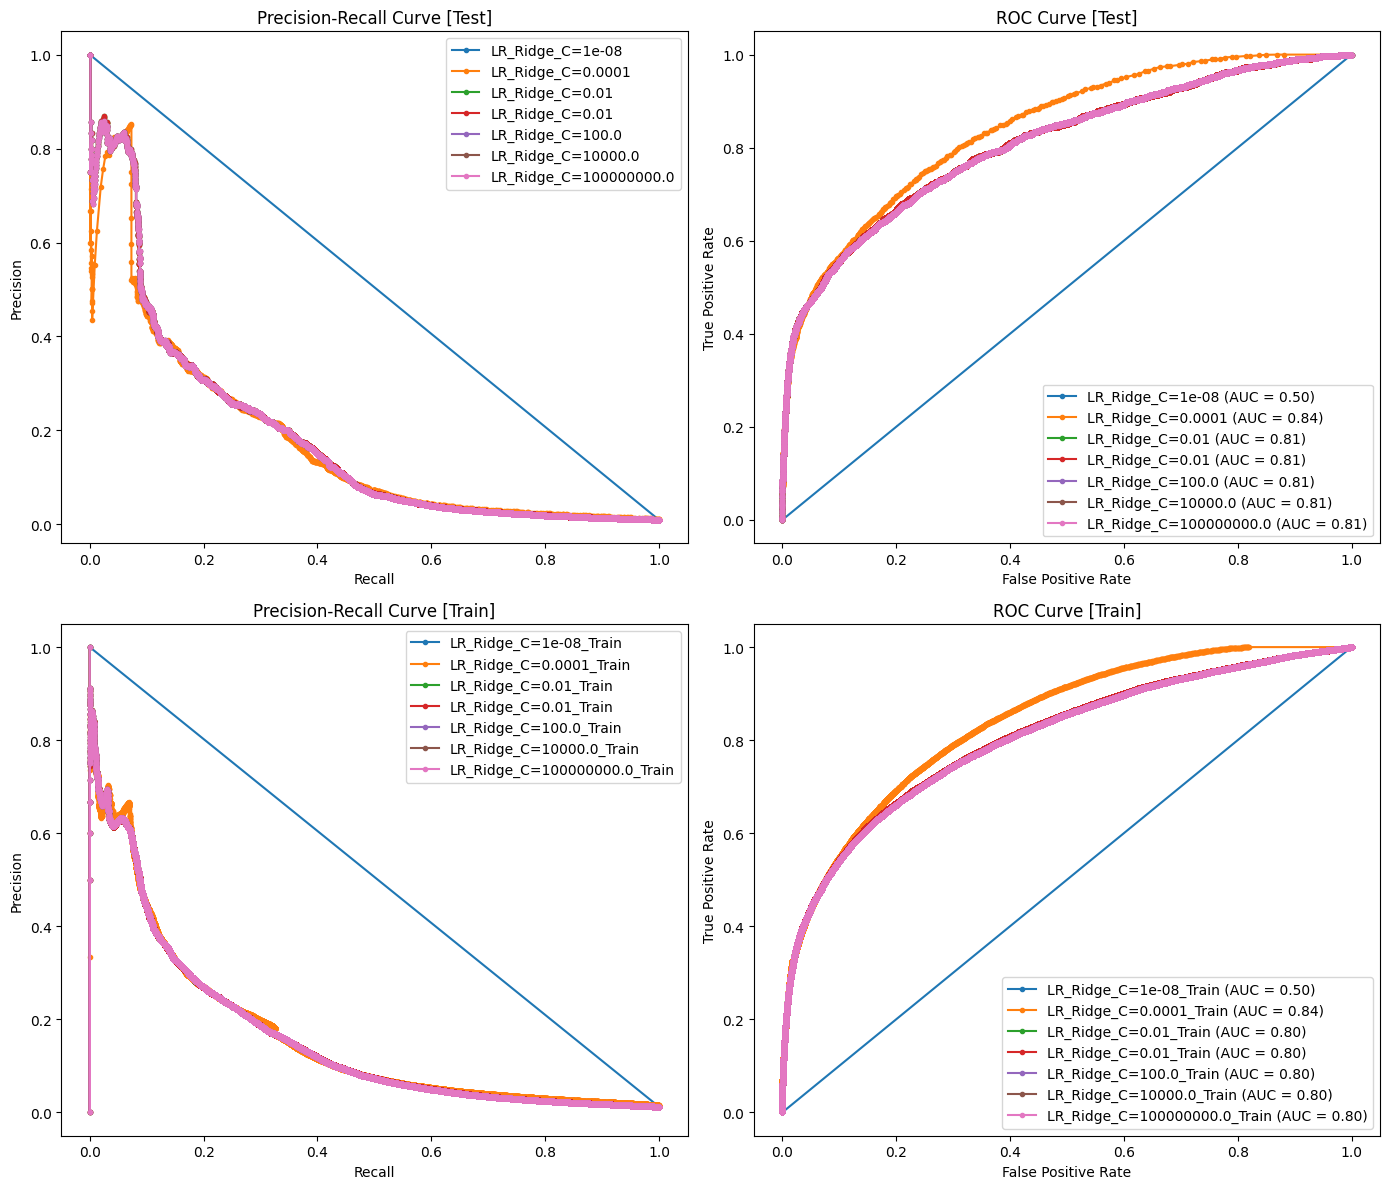

In [17]:
reg_values = [1e-8, 1e-4, 1e-2, 0.01, 1e2, 1e4, 1e8]
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
(ax_test_1, ax_test_2), (ax_train_1, ax_train_2) = axes



for c in reg_values:
    pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('log_reg', LogisticRegression(penalty='l1', solver='liblinear', C=c))
    ])
    pipeline.fit(X_train[train_cols], y_train)
    # Sobre test
    y_pred = pipeline.predict_proba(X_test[train_cols])[:, 1]
    generate_metrics(ax_test_1, ax_test_2, y_pred, y_test, label=f'LR_Lasso_C={c}')
    # Sobre train
    y_pred_train = pipeline.predict_proba(X_train[train_cols])[:, 1]
    generate_metrics(ax_train_1, ax_train_2, y_pred_train, y_train, label=f'LR_Lasso_C={c}_Train')


ax_test_1.set_title('Precision-Recall Curve [Test]')
ax_test_2.set_title('ROC Curve [Test]')
ax_train_1.set_title('Precision-Recall Curve [Train]')
ax_train_2.set_title('ROC Curve [Train]')

plt.tight_layout()
plt.show()

### Ridge

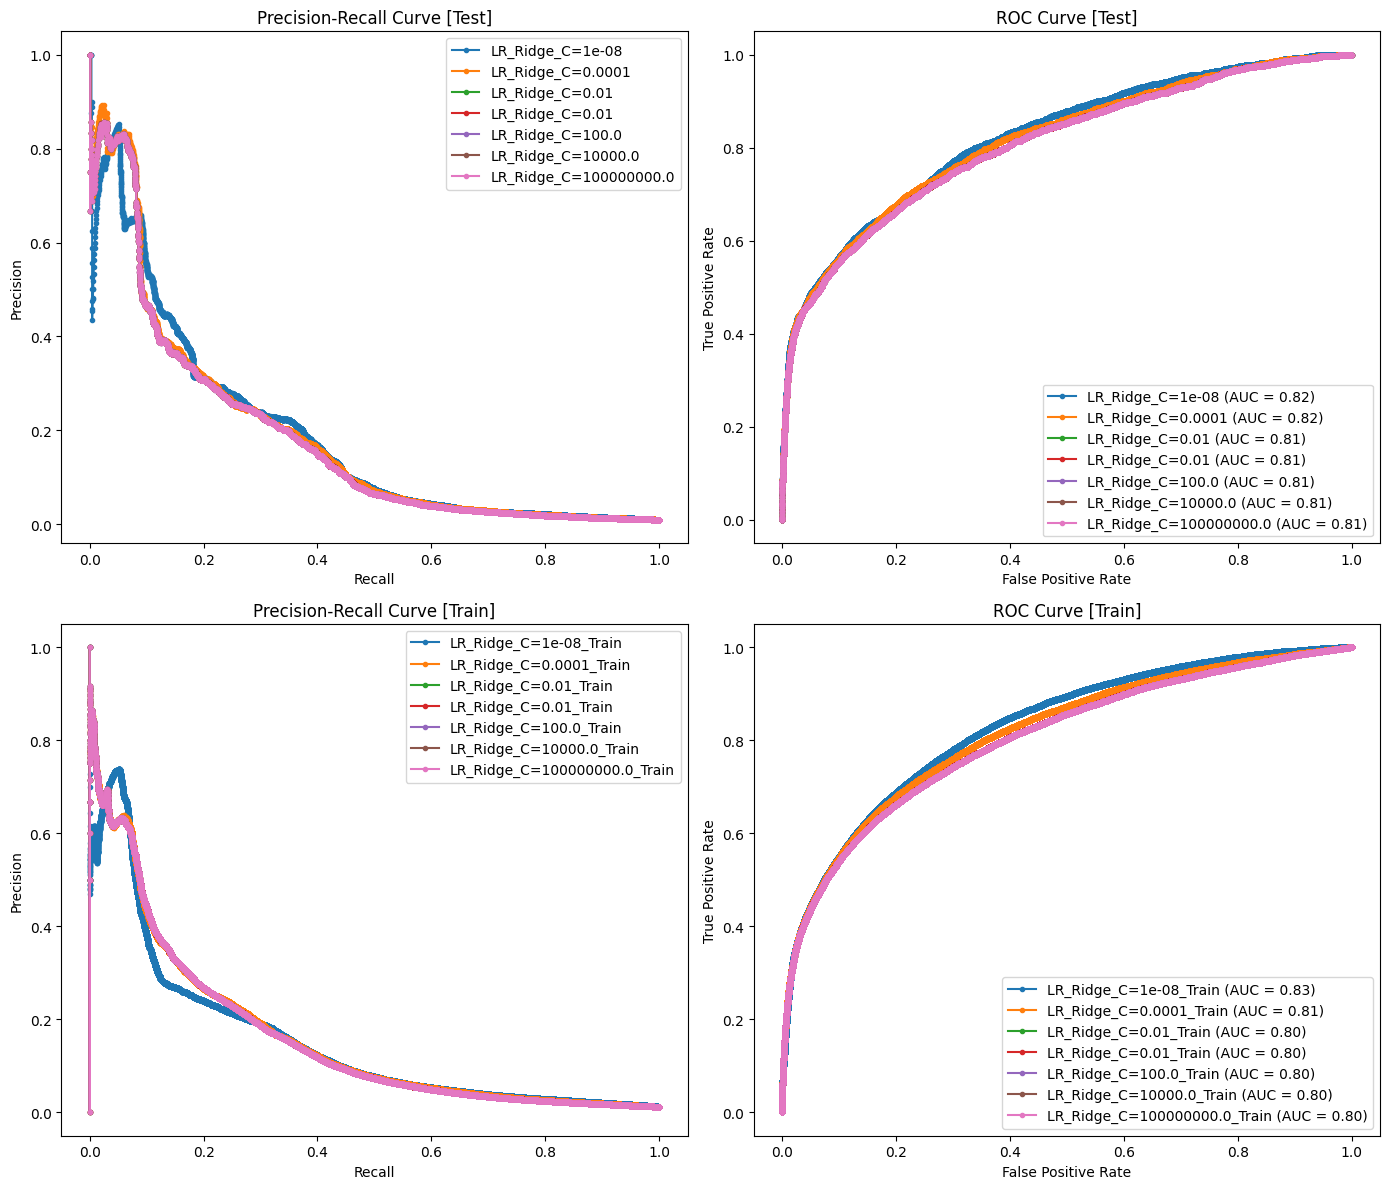

In [18]:
reg_values = [1e-8, 1e-4, 1e-2, 0.01, 1e2, 1e4, 1e8]
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
(ax_test_1, ax_test_2), (ax_train_1, ax_train_2) = axes



for c in reg_values:
    pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('log_reg', LogisticRegression(penalty='l2', C=c))
    ])
    pipeline.fit(X_train[train_cols], y_train)
    # Sobre test
    y_pred = pipeline.predict_proba(X_test[train_cols])[:, 1]
    generate_metrics(ax_test_1, ax_test_2, y_pred, y_test, label=f'LR_Ridge_C={c}')
    # Sobre train
    y_pred_train = pipeline.predict_proba(X_train[train_cols])[:, 1]
    generate_metrics(ax_train_1, ax_train_2, y_pred_train, y_train, label=f'LR_Ridge_C={c}_Train')


ax_test_1.set_title('Precision-Recall Curve [Test]')
ax_test_2.set_title('ROC Curve [Test]')
ax_train_1.set_title('Precision-Recall Curve [Train]')
ax_train_2.set_title('ROC Curve [Train]')

plt.tight_layout()
plt.show()

### Feature importance

Me quedo con uno de cada tipo para ver y seleccionar variables. A fin de construir un modelo simple que mantenga un poder predictivo similar.

Los modelos no están sobreajustando nada, porque no son lo suficientemente complejos para el problema, pero mejoran el baseline de forma clara.

In [54]:
# Selected Lasso
c_lasso = 1e8
pipeline_lasso_select = Pipeline([
('scaler', StandardScaler()),
('log_reg', LogisticRegression(penalty='l1', solver='liblinear', C=c_lasso))
])
pipeline_lasso_select.fit(X_train[train_cols], y_train)

# Selected Rdige
c_ridge = 1e-4
pipeline_ridge_select = Pipeline([
('scaler', StandardScaler()),
('log_reg', LogisticRegression(penalty='l2', C=c_ridge))
])
pipeline_ridge_select.fit(X_train[train_cols], y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('log_reg', LogisticRegression(C=1e-08))])

In [72]:
coefficients_lasso = pipeline_lasso_select.named_steps['log_reg'].coef_[0]
coefficients_ridge = pipeline_ridge_select.named_steps['log_reg'].coef_[0]

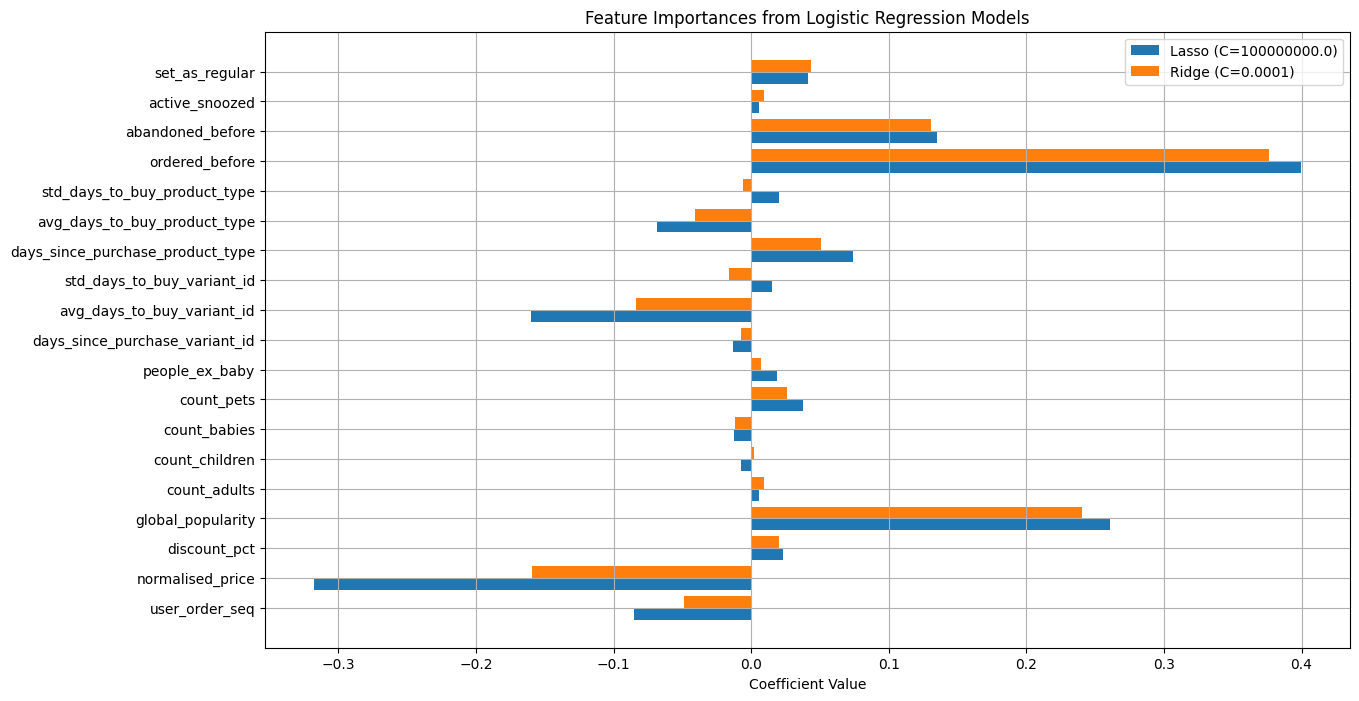

In [73]:
plt.figure(figsize=(14, 8))
height = 0.4
indices = np.arange(len(train_cols))

plt.barh(indices - height/2, coefficients_lasso, height=height, label=f'Lasso (C={c_lasso})')
plt.barh(indices + height/2, coefficients_ridge, height=height, label=f'Ridge (C={c_ridge})')

plt.yticks(indices, train_cols)
plt.xlabel('Coefficient Value')
plt.title('Feature Importances from Logistic Regression Models')
plt.legend()
plt.grid(True)
plt.show()

### Selección de variables

Entrenamos ahora un modelo con las variables más predicitivas.
* ordered_before
* abandoned_before
* avg_days_to_buy_variant_id
* global_popularity
* normalised_price

Y nos quedamos con el sin regularizar.

In [75]:
final_train_cols = ['ordered_before', 'abandoned_before', 'avg_days_to_buy_variant_id', 'global_popularity', 'normalised_price']

modelo_final = Pipeline([
('scaler', StandardScaler()),
('log_reg', LogisticRegression())
])
modelo_final.fit(X_train[final_train_cols], y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('log_reg', LogisticRegression())])

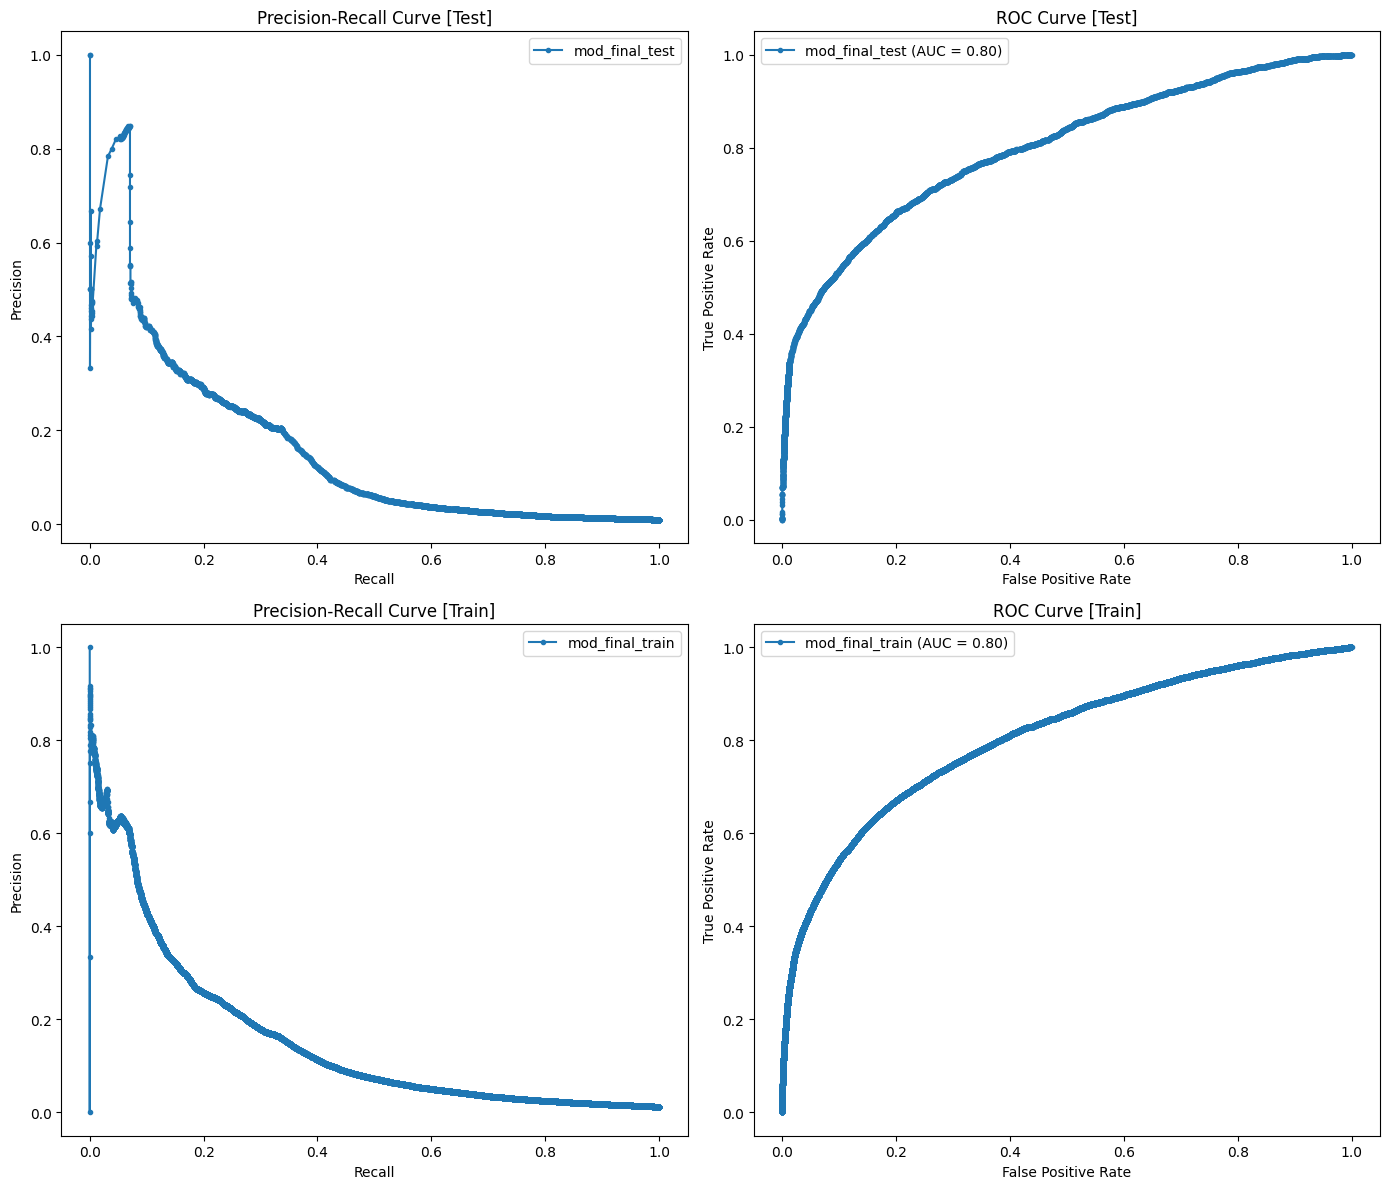

In [77]:
# Comparamos metricas
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
(ax_test_1, ax_test_2), (ax_train_1, ax_train_2) = axes

# sobre test
y_pred = modelo_final.predict_proba(X_test[final_train_cols])[:, 1]
generate_metrics(ax_test_1, ax_test_2, y_pred, y_test, label=f'mod_final_test')
# Sobre train
y_pred_train = modelo_final.predict_proba(X_train[final_train_cols])[:, 1]
generate_metrics(ax_train_1, ax_train_2, y_pred_train, y_train, label=f'mod_final_train')


ax_test_1.set_title('Precision-Recall Curve [Test]')
ax_test_2.set_title('ROC Curve [Test]')
ax_train_1.set_title('Precision-Recall Curve [Train]')
ax_train_2.set_title('ROC Curve [Train]')

plt.tight_layout()
plt.show()

Funciona bien, es simple, no mejora mucho del baseline en AUC, pero lo hace con una curva más vertical al principio, que es lo que nos interesa en este caso.

### Test con categoricas

In [80]:
# modelo categoricas
standard_scaler = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Debido a la alta cardinalidad de las categoricas tiramos por un hashencode de 20
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', max_categories=20))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', standard_scaler, final_train_cols),
        ('cat', categorical_transformer, categ_cols)
    ]
)

categ_model = pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('log_reg', LogisticRegression())
])

categ_model_cols = final_train_cols + categ_cols
categ_model.fit(X_train[categ_model_cols], y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['ordered_before',
                                                   'abandoned_before',
                                                   'avg_days_to_buy_variant_id',
                                                   'global_popularity',
                                                   'normalised_price']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 max_categories=20))]),
                                                  ['product_type',
                                                   'vendor'])])),
                ('log_reg', LogisticRegression())])

In [85]:
type(categ_model)

sklearn.pipeline.Pipeline

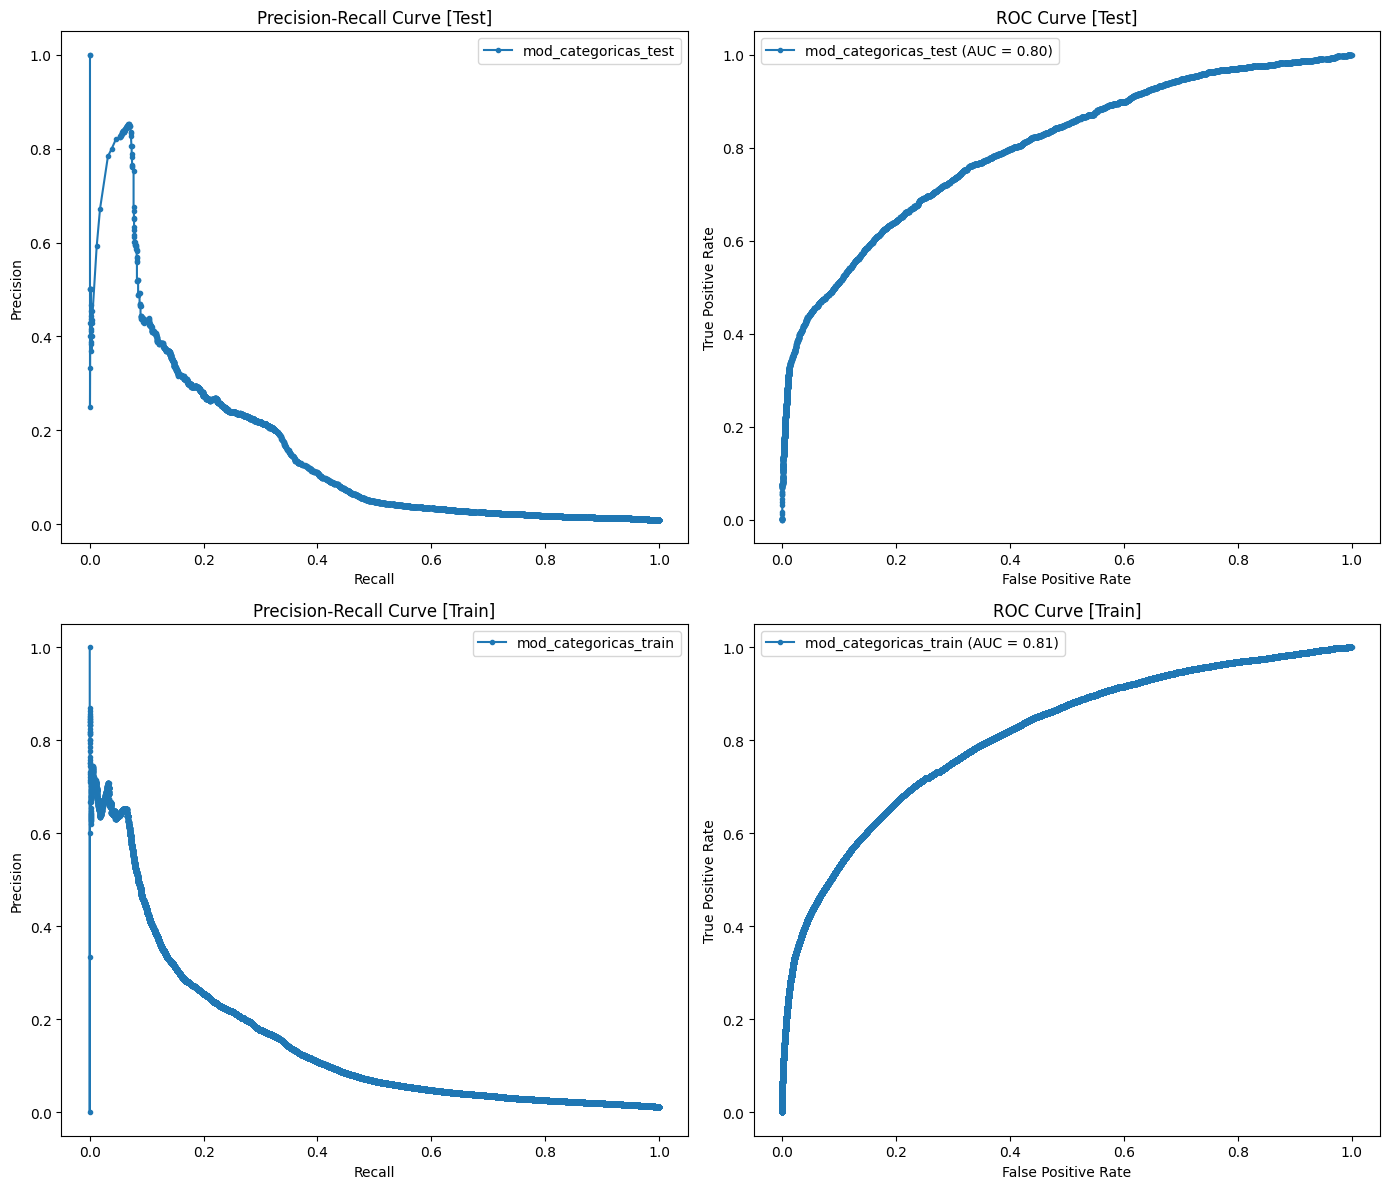

In [81]:
# Comparamos metricas
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
(ax_test_1, ax_test_2), (ax_train_1, ax_train_2) = axes

# sobre test
y_pred = categ_model.predict_proba(X_test[categ_model_cols])[:, 1]
generate_metrics(ax_test_1, ax_test_2, y_pred, y_test, label=f'mod_categoricas_test')
# Sobre train
y_pred_train = categ_model.predict_proba(X_train[categ_model_cols])[:, 1]
generate_metrics(ax_train_1, ax_train_2, y_pred_train, y_train, label=f'mod_categoricas_train')


ax_test_1.set_title('Precision-Recall Curve [Test]')
ax_test_2.set_title('ROC Curve [Test]')
ax_train_1.set_title('Precision-Recall Curve [Train]')
ax_train_2.set_title('ROC Curve [Train]')

plt.tight_layout()
plt.show()

Que queda bastante parecido a los otros, manteniendo la verticalidad del princpio de la ROC. Nos quedamos con el modelo de 5 variables, por ser más simple y explicar el problema igual.